In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.bezier as bezier
from scipy.special import comb


In [3]:

class Ray:
    """
    The Ray class defines a ray in 2D space. The ray is launched from the 
    initial position x_init, y_init and the direction is defined by theta.
    """
    courant_number_2D = 1 # courant_number_2d < c_max = 1/sqrt(2) for two dimensions
    velocity = 400
    dx = dy = 1e-6

    def __init__(self, x_init, y_init, theta, uray_intensity, ray_id):
        self.ray_id = ray_id
        self.x_init = x_init
        self.y_init = y_init
        self.theta = theta
        self.velocity_x = self.velocity * np.cos(self.theta)
        self.velocity_y = self.velocity * np.sin(self.theta)
        self.dt = Ray.courant_number_2D * min(Ray.dx, Ray.dy) / np.sqrt(self.velocity_x**2 + self.velocity_y**2)
        self.uray_intensity = uray_intensity

    def next_position(self, grid_vector_field_gradient):
        """
        Returns the next position of the ray at time t and updates initial positions.
        Recalculates the time step based on the current velocity.
        Updates velocity based on the grid vector field.
        """
        # get cell position of ray 
        x_cell = int(self.x_init / Ray.dx)
        y_cell = int(self.y_init / Ray.dy)

        # calculate time step based on velocity
        self.dt = Ray.courant_number_2D * min(Ray.dx, Ray.dy) / np.sqrt(self.velocity_x**2 + self.velocity_y**2)

        # get gradient of vector field at cell position
        self.velocity_x += grid_vector_field_gradient[x_cell, y_cell, 0]
        self.velocity_y += grid_vector_field_gradient[x_cell, y_cell, 1]
        # print(self.velocity_x, self.velocity_y)
        # calculate next position
        x = self.x_init + self.velocity_x * self.dt
        y = self.y_init + self.velocity_y * self.dt

        # update initial position
        self.x_init = x
        self.y_init = y

        return x, y
        

In [124]:


grid_resolution = 100
grid_cell_size = 1e-6
# define grid vector field for 2D space with linear gradient in y direction from 1 to 4 and linear gradient in x direction from 2 to 3
grid_density = np.zeros((grid_resolution, grid_resolution, 2))
grid_density[:, :, 0] = np.linspace(40, 200, grid_resolution).reshape(1, grid_resolution)
grid_density[:, :, 1] = np.linspace(40, 200, grid_resolution).reshape(grid_resolution, 1)
# gradient of the grid vector field calculated numerically using central difference method. roll the vectors to the left and right to calculate the gradient
grid_density_gradient = np.zeros((grid_resolution, grid_resolution, 2))
grid_density_gradient[:, :, 0] = np.gradient(grid_density[:, :, 0], axis = 1)
grid_density_gradient[:, :, 1] = np.gradient(grid_density[:, :, 1], axis = 0)

# beam parameters
beam_range_min = grid_cell_size * grid_resolution/2
beam_range_max = grid_cell_size * grid_resolution/2 + 20 * grid_cell_size

# introducing intensity to the rays trajectory
sigma = 0.0375
intensity_profile = np.exp(-1*((np.linspace(-.05,.05,100)/sigma)**2)**(5/2))



In [125]:
# np.interp(0, np.linspace(beam_range_min, beam_range_max, 100), intensity_profile)
# plt.plot(np.linspace(beam_range_min, beam_range_max, 100), intensity_profile)

In [126]:
# generate 100 rays from the left edge of the grid and directions and store their paths in a list ray_path_seed
Ray.courant_number_2D = 1
ray_count = 20
spacer = 20
intensity_profile = np.exp(-1*((np.linspace(-.05,.05,ray_count)/sigma)**2)**(5/2))
ray_paths_seed = []
for ray_id in range(ray_count):
    ray = Ray(0, grid_cell_size * grid_resolution/2 + ray_id / (ray_count/spacer) * grid_cell_size, 0, intensity_profile[ray_id], ray_id)
    ray.ray_path = np.array([ray.x_init, ray.y_init])
    while ray.x_init < grid_resolution * grid_cell_size and ray.y_init < grid_resolution * grid_cell_size:
        x, y = ray.next_position(grid_density_gradient)
        # append new position to ray path
        ray.ray_path = np.vstack((ray.ray_path, np.array([x, y])))
    ray_paths_seed.append(ray.ray_path)

# generate rays from the bottom of the grid and store their paths in a separate list ray_paths_pump
ray_paths_pump = []
beam_range_min = grid_cell_size * grid_resolution/2
beam_range_max = grid_cell_size * grid_resolution/2 + 20 * grid_cell_size
for ray_id in range(ray_count):
    ray = Ray(grid_cell_size * grid_resolution/2 + ray_id / (ray_count/spacer) * grid_cell_size, 0, np.pi/2, intensity_profile[ray_id], ray_id)
    ray.ray_path = np.array([ray.x_init, ray.y_init])
    while ray.x_init < grid_resolution * grid_cell_size and ray.y_init < grid_resolution * grid_cell_size:
        x, y = ray.next_position(grid_density_gradient)
        # append new position to ray path
        ray.ray_path = np.vstack((ray.ray_path, np.array([x, y])))
    ray_paths_pump.append(ray.ray_path)


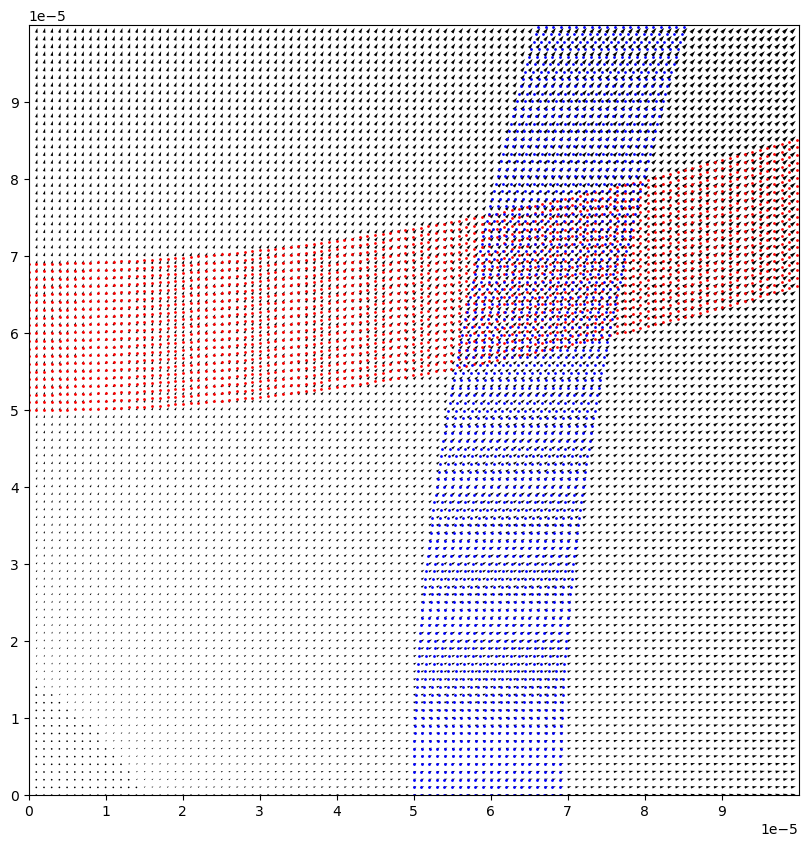

In [127]:

# plot ray path for all rays in the list
fig, ax = plt.subplots()
# figure size larger
fig.set_size_inches(10, 10)
ax.set_aspect('equal')
ax.set_xlim(0, grid_resolution * grid_cell_size)
ax.set_ylim(0, grid_resolution * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size*10))
ax.set_yticks(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size*10))

ax.quiver(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size),
            np.arange(0, grid_resolution * grid_cell_size, grid_cell_size),
            grid_density[:, :, 0], grid_density[:, :, 1], color='k')

for ray_path in ray_paths_seed:
    # ax.plot(ray_path[:, 0], ray_path[:, 1], color='r')
    # scatter all points
    ax.scatter(ray_path[:, 0], ray_path[:, 1], color='r', s=1)

for ray_path in ray_paths_pump:
    # ax.plot(ray_path[:, 0], ray_path[:, 1], color='b')
    ax.scatter(ray_path[:, 0], ray_path[:, 1], color='b', s=1)
plt.show()




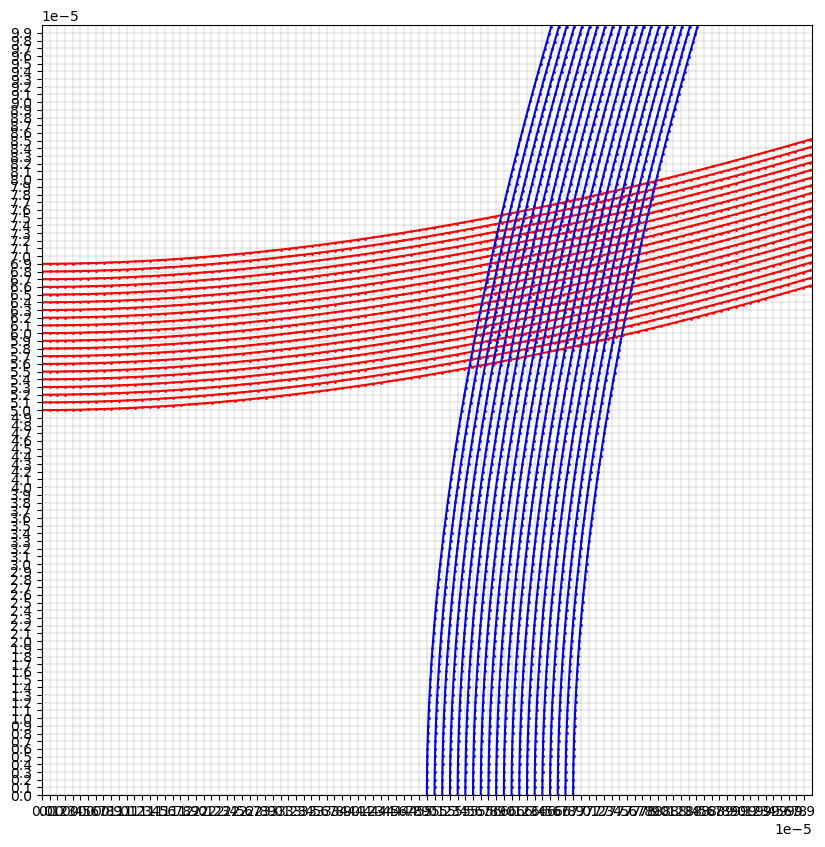

In [128]:
# plot ray path for all rays in the list on a grid
fig, ax = plt.subplots()
# figure size larger
fig.set_size_inches(10, 10)
ax.set_aspect('equal')
ax.set_xlim(0, grid_resolution * grid_cell_size)
ax.set_ylim(0, grid_resolution * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size))
ax.set_yticks(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size))

# gridlines 100x100
ax.grid(color='k', linestyle='-', linewidth=0.1)

# no quiver
# ax.quiver(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size),
#             np.arange(0, grid_resolution * grid_cell_size, grid_cell_size),
#             grid_density[:, :, 0], grid_density[:, :, 1], color='k')

# plot all points
for ray_path in ray_paths_seed:
    ax.plot(ray_path[:, 0], ray_path[:, 1], color='r')
    ax.scatter(ray_path[:, 0], ray_path[:, 1], color='r', s=1)
    
for ray_path in ray_paths_pump:
    ax.plot(ray_path[:, 0], ray_path[:, 1], color='b')
    ax.scatter(ray_path[:, 0], ray_path[:, 1], color='b', s=1)

plt.show()

In [129]:
def raster_rays_to_bezier(raster_points, number_of_control_points = 3, tolerance = 5, limit_control_points = 100, plot = False, plot_control = False):
    """
    raster_points: np.array[n, 2] ; n is the number of pixels rastered
    number_of_control_points: starting expected number of control points
    tolerance: difference between raster and bezier
    limit_control_points: max number of control points
    """
    x, y = raster_points.T
    if plot:
        plt.plot(x,y)

    length = len(x)
    # https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
    # solves an arbitrary curve for a bezier using all points. produces a bezier curve with number_of_control_points

    matrix = lambda n, t, k: t ** (k) * (1-t) ** (n-k) * comb(n, k) # n: polynomial degree, t: parameter, k: current term
    get_bezier = lambda parameter_range, num_control_points: np.array([[
        matrix(num_control_points-1, t, k) for k in range(num_control_points)] for t in parameter_range
        ])

    def least_squares_fit(points, matrix):
        matrix_ = np.linalg.pinv(matrix)
        return np.matmul(matrix_,points)

    points = np.array(list(zip(x, y)))
    while True:
        control_points = least_squares_fit(points, get_bezier(np.linspace(0,1,length),number_of_control_points))
        bezier_curve = bezier.BezierSegment(control_points)
        bezier_plot_points = np.array(bezier_curve.point_at_t(np.linspace(0,1,length)))
        if(np.sum(np.abs(bezier_plot_points - points)) < tolerance or number_of_control_points >= limit_control_points):
            break
        number_of_control_points += 1
    # print("Control Points: ", number_of_control_points, "Difference: ", np.sum(np.abs(bezier_plot_points - points)))
    if plot_control:
        plt.scatter(*control_points.T)
    if plot:
        plt.plot(*bezier_plot_points.T, linestyle='-.')
    return control_points, bezier_curve


In [130]:
len(ray_paths_seed[0])

103

In [131]:
# get size in bytes of the ray paths
print("Size of ray paths in bytes: ", len(ray_paths_seed[0]) * 2 * len(ray_paths_seed) * 8 + len(ray_paths_pump[0]) * 2 * len(ray_paths_pump) * 8)


Size of ray paths in bytes:  65920


In [132]:
bezier_curves_seed = []
seed_control_points = []
bezier_curves_pump = []
pump_control_points = []
for ray_path in ray_paths_seed:
    bezier_curves_seed.append(raster_rays_to_bezier(ray_path, 4))
    seed_control_points.append(bezier_curves_seed[0])
for ray_path in ray_paths_pump:
    bezier_curves_pump.append(raster_rays_to_bezier(ray_path, 4))
    pump_control_points.append(bezier_curves_pump[0])

# get size in bytes of the bezier curves
print("Size of bezier curves in bytes: ", len(seed_control_points) * 2 * 8 * 4 + len(pump_control_points) * 2 * 8 * 4)

Size of bezier curves in bytes:  2560


[[-9.90242821e-09  4.99874983e-05]
 [ 1.02634803e-04  4.71575845e-07]
 [-1.17105127e-06  1.97928552e-05]
 [-7.40580853e-07 -3.84366249e-06]]
[[-9.90242821e-09  4.99874983e-05]
 [ 3.42016985e-05  5.01446903e-05]
 [ 6.80229490e-05  5.68995007e-05]
 [ 1.00713268e-04  6.64082669e-05]]


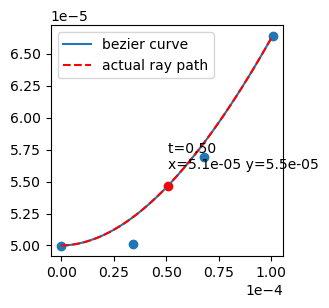

In [133]:
seed_ray_1_bezier = bezier_curves_seed[0][1]
seed_ray_2_bezier = bezier_curves_seed[1][1]
grid_x_crossings = np.linspace(0, grid_resolution * grid_cell_size, grid_resolution)
grid_y_crossings = np.linspace(0, grid_resolution * grid_cell_size, grid_resolution)

t = 0.5
seed_ray_1_bezier.point_at_t(t)
print(seed_ray_1_bezier.polynomial_coefficients)
print(seed_ray_1_bezier.control_points)

plt.figure(figsize=(3,3))

# annotate the point showing the t, x, y values
plt.scatter(*seed_ray_1_bezier.point_at_t(t), color='r')
x_at_t, y_at_t = seed_ray_1_bezier.point_at_t(t)

plt.annotate(f"t={t:.2f} \nx={x_at_t:.2} y={y_at_t:.2}\n", (x_at_t, y_at_t))
plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.scatter(*np.array(seed_ray_1_bezier.control_points).T)
plt.plot(*np.array(seed_ray_1_bezier.point_at_t(np.linspace(0,1,100))).T, label='bezier curve')
plt.plot(ray_paths_seed[0][:, 0], ray_paths_seed[0][:, 1], color='r', linestyle='--', label='actual ray path')
plt.legend()

[[ -1.     1.  ]
 [  7.5   -7.5 ]
 [-15.    15.  ]
 [  8.75  -8.75]]
[0.91141204 0.59053314 0.21234054]
(array([2.95569393, 2.95569393]), array([2.26863128, 2.26863128]), array([1.23223456, 1.23223456]))


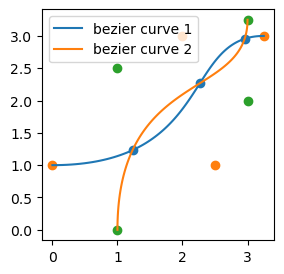

In [134]:
bezier_curve_1 = bezier.BezierSegment([[0,1],[2.5,1],[2,3],[3.25,3]]) # left to right
bezier_curve_2 = bezier.BezierSegment([[1,0],[1,2.5],[3,2],[3,3.25]]) # bottom to top

# order of coefficients is [x^n, x^(n-1),..., x, 1]
difference = bezier_curve_1.polynomial_coefficients - bezier_curve_2.polynomial_coefficients 
# roots of this polynomial are the t values where the two curves intersect
print(difference)
# get the roots of the polynomial
roots_x = np.roots(difference[:,0][::-1])
roots_y = np.roots(difference[:,1][::-1])
# filter out the roots that are not between 0 and 1
print(roots_x)
roots_x = roots_x[np.logical_and(roots_x >= 0, roots_x <= 1)]
roots_y = roots_y[np.logical_and(roots_y >= 0, roots_y <= 1)]

# get the points where the two curves intersect
intersection_points = bezier_curve_1.point_at_t(roots_x)

print(intersection_points)
plt.figure(figsize=(3,3))
plt.scatter(*np.array(intersection_points).T)

plt.plot(*np.array(bezier_curve_1.point_at_t(np.linspace(0,1,100))).T, label='bezier curve 1')
plt.plot(*np.array(bezier_curve_2.point_at_t(np.linspace(0,1,100))).T, label='bezier curve 2')
# plot control points
plt.scatter(*np.array(bezier_curve_1.control_points).T)
plt.scatter(*np.array(bezier_curve_2.control_points).T)
plt.legend()

400


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


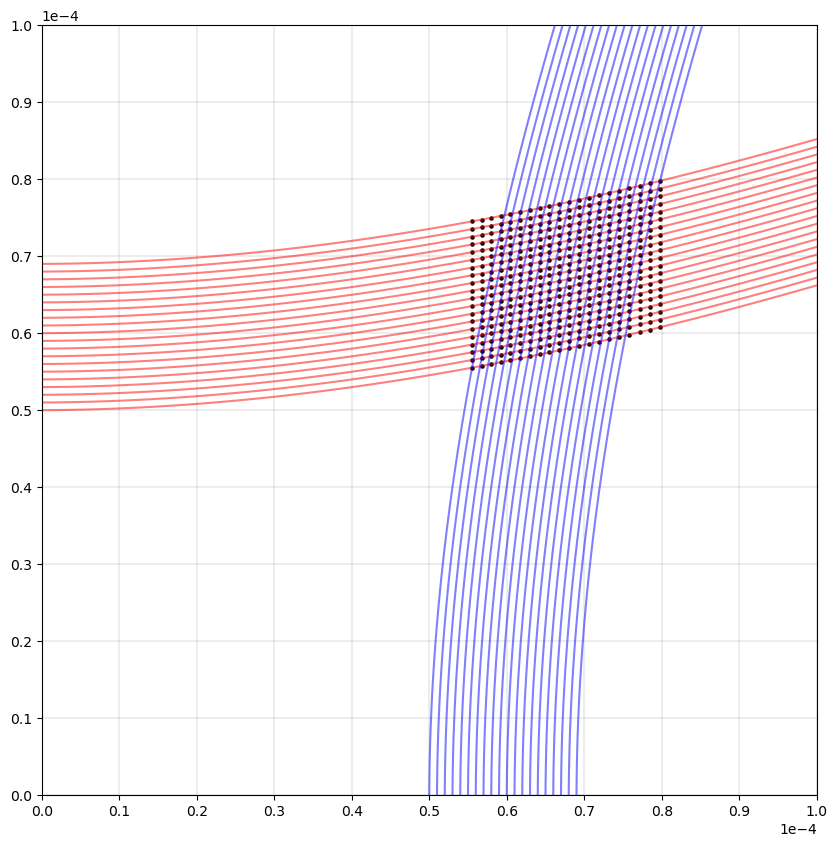

In [135]:
# turning the above into a function to get the intersection of two bezier curves
def get_bezier_curve_intersection(bezier_curve_1, bezier_curve_2):
    difference = bezier_curve_1.polynomial_coefficients - bezier_curve_2.polynomial_coefficients 
    # roots of this polynomial are the t values where the two curves intersect
    roots_x = np.roots(difference[:,0][::-1])
    roots_y = np.roots(difference[:,1][::-1])
    # filter out the roots that are not between 0 and 1
    roots_x = roots_x[np.logical_and(roots_x >= 0, roots_x <= 1)]
    roots_y = roots_y[np.logical_and(roots_y >= 0, roots_y <= 1)]
    # points where two curves intersect are where roots_x == roots_y
    intersection_points = bezier_curve_1.point_at_t(roots_x)
    return intersection_points

# get the intersection points of all the rays
intersection_points = []
for i in range(len(bezier_curves_seed)):
    for j in range(len(bezier_curves_pump)):
        point = get_bezier_curve_intersection(bezier_curves_seed[i][1], bezier_curves_pump[j][1])
        intersection_points.append(point)

# plot the intersection points over all the curves

print(len(intersection_points))
plt.figure(figsize=(10,10))

for i in range(len(bezier_curves_seed)):
    plt.plot(*np.array(bezier_curves_seed[i][1].point_at_t(np.linspace(0,1,100))).T, alpha=.5,label='bezier curve 1', c= 'r')
for i in range(len(bezier_curves_pump)):
    plt.plot(*np.array(bezier_curves_pump[i][1].point_at_t(np.linspace(0,1,100))).T, alpha=.5,label='bezier curve 2', c= 'b')
plt.xlim(0, grid_resolution * grid_cell_size)
plt.ylim(0, grid_resolution * grid_cell_size)
plt.xticks(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size))
plt.yticks(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size))
# tick label at every 10th gridline
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(grid_cell_size*10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(grid_cell_size*10))

# gridlines 100x100
plt.grid(color='k', linestyle='-', linewidth=0.1)

plt.scatter(*np.array(intersection_points).T, s=5, c='black')
plt.ticklabel_format(style='sci', scilimits=(0,0))


In [144]:
def de_casteljau_subdivision(P, Q, tol=1e-8):
    # Subdivide the curves recursively until they are close enough
    def subdivide_curve(P, Q):
        # Compute the control polygons of the two curves
        mP = [(P[i] + P[i+1]) / 2 for i in range(len(P)-1)]
        mQ = [(Q[i] + Q[i+1]) / 2 for i in range(len(Q)-1)]
        
        # If the control polygons are close enough, return their intersection points
        if distance(mP[-1][0], mQ[-1][0]) < tol:
            return [(mP[-1][0], mQ[-1][0])]
        
        # Otherwise, subdivide the curves and compute their intersection points
        P1, P2 = [P[0]] + mP, mP + [P[-1]]
        Q1, Q2 = [Q[0]] + mQ, mQ + [Q[-1]]
        return subdivide_curve(P1, Q1) + subdivide_curve(P2, Q2)
    
    # Extract the control points of the Bezier curves
    P_controls = P.vertices.tolist()
    Q_controls = Q.vertices.tolist()
    
    # Subdivide the curves and compute their intersection points
    return subdivide_curve(P_controls, Q_controls)


In [149]:
from matplotlib.path import Path

controls1 = bezier_curves_pump[0][0]
controls2 = bezier_curves_seed[0][0]

path1 = Path(controls1)
path2 = Path(controls2)

# get the intersection point of the two curves
path1.intersect_path(path2)

AttributeError: 'Path' object has no attribute 'intersect_path'

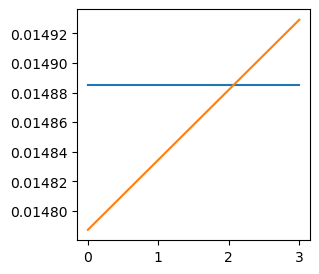

In [115]:
# interpolate the intensity of the pump beam across the rays

# introducing intensity to the rays trajectory

sigma = 0.0375
intensity_profile = np.exp(-1*((np.linspace(-.05,.05,ray_count)/sigma)**2)**(5/2))

intensity_profile_pump = []
for i in range(len(bezier_curves_pump)):
    pump_intensity = np.interp(bezier_curves_pump[i][0], np.linspace(0,1,ray_count), intensity_profile)

intensity_profile_seed = []
for i in range(len(bezier_curves_seed)):
    seed_intensity = np.interp(bezier_curves_seed[i][0], np.linspace(0,1,ray_count), intensity_profile)

# plot the intensity profile of the pump beam
plt.figure(figsize=(3,3))
plt.plot(pump_intensity)

In [108]:
# redo this whole exercise in 3D space
# define grid vector field for 3D space with linear gradient in z direction from 1 to 4 and linear gradient in x direction from 1 to 2
grid_resolution_3D = 100
grid_vector_field_3D = np.zeros((grid_resolution_3D, grid_resolution_3D, grid_resolution_3D, 3))
grid_vector_field_3D[:, :, :, 2] = np.linspace(1, 4, grid_resolution_3D).reshape(grid_resolution_3D, 1, 1)
grid_vector_field_3D[:, :, :, 0] = np.linspace(1, 2, grid_resolution_3D).reshape(1, grid_resolution_3D, 1)


In [109]:
# redefine ray class for 3D space
class Ray3D:
    courant_number_3D = 0.1
    velocity = 4000
    dx = dy = dz = 1e-6

    def __init__(self, x_init, y_init, z_init, theta, phi):
        self.x_init = x_init
        self.y_init = y_init
        self.z_init = z_init
        self.theta = theta
        self.phi = phi
        self.velocity_x = self.velocity * np.sin(self.theta) * np.cos(self.phi)
        self.velocity_y = self.velocity * np.sin(self.theta) * np.sin(self.phi)
        self.velocity_z = self.velocity * np.cos(self.theta)
        self.dt = Ray3D.courant_number_3D * min(Ray3D.dx, Ray3D.dy, Ray3D.dz) / np.sqrt(self.velocity_x**2 + self.velocity_y**2 + self.velocity_z**2)


    def next_position(self, grid_vector_field):
        """
        Returns the next position of the ray at time t and updates initial positions.
        Recalculates the time step based on the current velocity.
        Updates velocity based on the grid vector field.
        """
        # update velocity based on grid vector field
        self.velocity_x += grid_vector_field[int(self.x_init/self.dx), int(self.y_init/self.dy), int(self.z_init/self.dz), 0]
        self.velocity_y += grid_vector_field[int(self.x_init/self.dx), int(self.y_init/self.dy), int(self.z_init/self.dz), 1]
        self.velocity_z += grid_vector_field[int(self.x_init/self.dx), int(self.y_init/self.dy), int(self.z_init/self.dz), 2]

        # calculate time step based on velocity
        self.dt = self.courant_number_3D * min(self.dx, self.dy, self.dz) / np.sqrt(self.velocity_x**2 + self.velocity_y**2 + self.velocity_z**2)

        # calculate next position
        x = self.x_init + self.velocity_x * self.dt
        y = self.y_init + self.velocity_y * self.dt
        z = self.z_init + self.velocity_z * self.dt

        # update initial position
        self.x_init = x
        self.y_init = y
        self.z_init = z

        return x, y, z
    

In [32]:
# generate initial positions of rays within a disc of radius 10 grid cells in the middle of the xz plane
# and store their paths in a list called ray_paths_seed_3D
ray_paths_seed_3D = []
for i in range(100):
    for j in range(100):
        if(np.sqrt((i - 50)**2 + (j - 50)**2) < 10):
            ray = Ray3D(i * grid_cell_size, 0, j * grid_cell_size, np.pi/2, np.pi/2)
            ray_path = np.array([ray.x_init, ray.y_init, ray.z_init])
            while ray.x_init < grid_resolution_3D * grid_cell_size and ray.y_init < grid_resolution_3D * grid_cell_size and ray.z_init < grid_resolution_3D * grid_cell_size:
                ray_path = np.vstack((ray_path, ray.next_position(grid_vector_field_3D)))
            ray_paths_seed_3D.append(ray_path)

# generate initial positions of rays within a disc of radius 10 grid cells in the middle of the xy plane
# and store their paths in a list called ray_paths_pump_3D
ray_paths_pump_3D = []
for i in range(100):
    for j in range(100):
        if(np.sqrt((i - 50)**2 + (j - 50)**2) < 10):
            ray = Ray3D(i * grid_cell_size, j * grid_cell_size, 0, 0, 0)
            ray_path = np.array([ray.x_init, ray.y_init, ray.z_init])
            while ray.x_init < grid_resolution_3D * grid_cell_size and ray.y_init < grid_resolution_3D * grid_cell_size and ray.z_init < grid_resolution_3D * grid_cell_size:
                ray_path = np.vstack((ray_path, ray.next_position(grid_vector_field_3D)))
            ray_paths_pump_3D.append(ray_path)
            

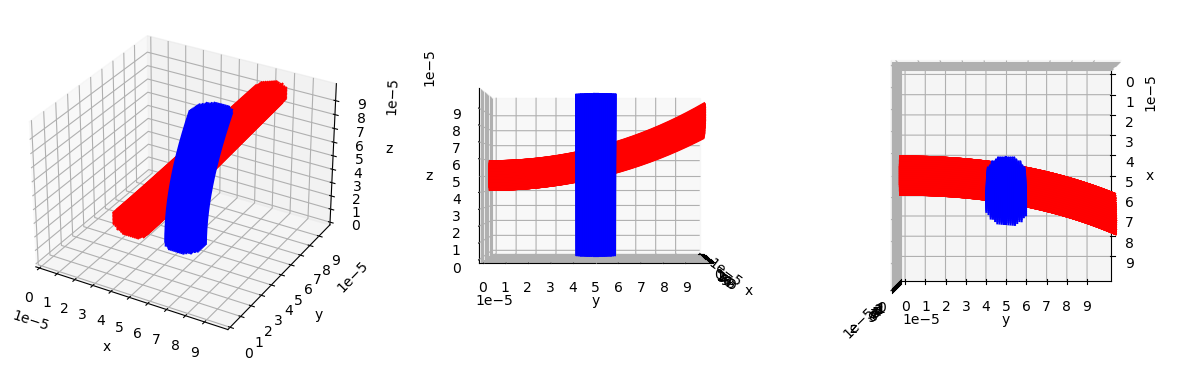

In [40]:
# plot ray path for all rays in the list

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(131, projection='3d')
ax.set_aspect('auto')
ax.set_xlim(0, grid_resolution_3D * grid_cell_size)
ax.set_ylim(0, grid_resolution_3D * grid_cell_size)
ax.set_zlim(0, grid_resolution_3D * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_yticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_zticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
# label axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for ray_path in ray_paths_seed_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='r')

for ray_path in ray_paths_pump_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='b')


ax = fig.add_subplot(132, projection='3d')
ax.set_aspect('auto')
ax.set_xlim(0, grid_resolution_3D * grid_cell_size)
ax.set_ylim(0, grid_resolution_3D * grid_cell_size)
ax.set_zlim(0, grid_resolution_3D * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_yticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_zticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
# label axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for ray_path in ray_paths_seed_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='r')

for ray_path in ray_paths_pump_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='b')

# reposition camera to view the plot from the yz side
ax.view_init(0,0)


ax = fig.add_subplot(133, projection='3d')
ax.set_aspect('auto')
ax.set_xlim(0, grid_resolution_3D * grid_cell_size)
ax.set_ylim(0, grid_resolution_3D * grid_cell_size)
ax.set_zlim(0, grid_resolution_3D * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_yticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_zticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
# label axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for ray_path in ray_paths_seed_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='r')

for ray_path in ray_paths_pump_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='b')

# reposition camera to view the plot from the yz side
ax.view_init(90,0)

